Movie Recommender

In this project we will be building a Movie Recommender system using collaborative filtering that will predict a movie based on your interactions


## Importing Packages 

In [46]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline

In [26]:
#Loading dataset
movies = pd.read_csv("ml-latest-small/ml-latest-small/movies.csv")
ratings =  pd.read_csv("ml-latest-small/ml-latest-small/ratings.csv")



In [27]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
#Number of ratings, movies and users we have in our data set 
total_ratings =len(ratings)
total_movies=ratings['movieId'].nunique()
total_users =ratings['userId'].nunique()

print(f"Total ratings{total_ratings}")
print(f"Total movies{total_movies}")
print(f"Total users{total_users}")


Total ratings100836
Total movies9724
Total users610


In [29]:
nullmovies = movies.isnull().sum()
nullratings = ratings.isnull().sum()
print(f"nulls in movie dataset {nullmovies}")
print(f"nulls in ratings dataset {nullratings}")

nulls in movie dataset movieId    0
title      0
genres     0
dtype: int64
nulls in ratings dataset userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


### EDA


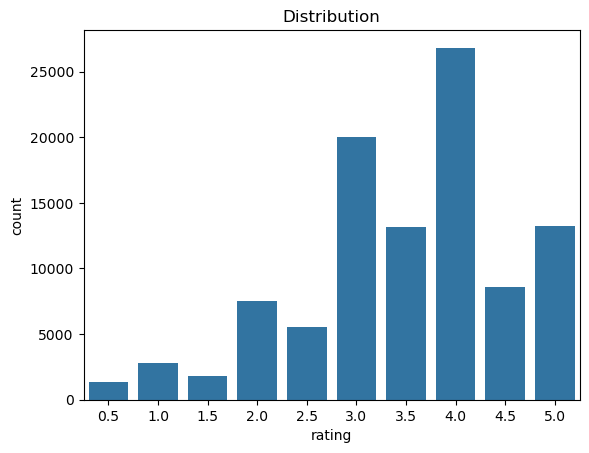

In [30]:
sns.countplot(x='rating',data=ratings)
plt.title('Distribution')
plt.show()

In [31]:
#The top 5 rated movies
movie_ratings = ratings.merge(movies, on='movieId')
top_movies = movie_ratings['title'].value_counts().nlargest(5)
print(top_movies)

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: count, dtype: int64


In [32]:
#The last 5 rated movies
lowest_movies = movie_ratings['title'].value_counts().nsmallest(5)
print(lowest_movies)

title
Julia (2014)                  1
You Only Live Once (1937)     1
Music Box (1989)              1
Getaway (2013)                1
Ricki and the Flash (2015)    1
Name: count, dtype: int64


In [33]:
#Top 10 genre 
#Split the genres to a list
movies['genres'] =  movies['genres'].apply(lambda x: x.split ('|'))

total_genre = Counter(g for genres in movies ['genres'] for g in genres)

print(f'No of genres{len(total_genre)}')

No of genres20


C:\Users\Joseph\AppData\Local\Temp\ipykernel_4260\2386159201.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=top_genre_df, palette="viridis")


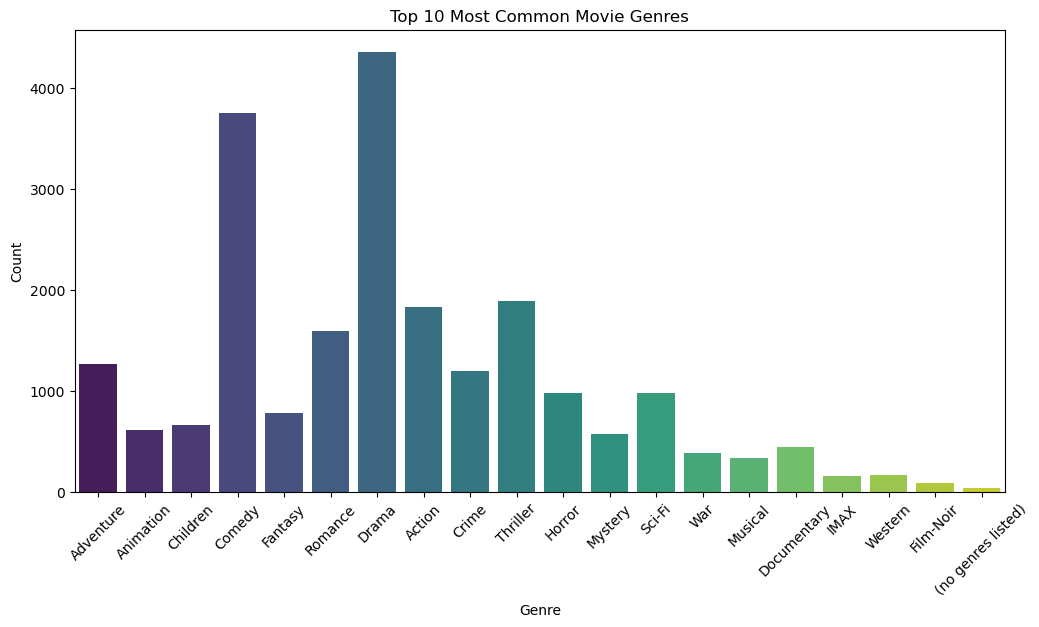

In [34]:
#Top 10 genre visualization
#Change  to dataframe 
top_genre_df = pd.DataFrame([total_genre]).T.reset_index()
top_genre_df.columns = ['genre','count']
plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='count', data=top_genre_df, palette="viridis")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Top 10 Most Common Movie Genres")
plt.xticks(rotation=45)  
plt.show()

In [ ]:
movies['rating'].value_counts()

### Data Processing

In [35]:
# 9724 number of users hence Item based filtering model 
#Create User-Item Matrix: 
# Transform the data into a user-item matrix where rows represent users and columns represent movies.
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix.shape


(610, 9724)

In [36]:
#Normalization
scaler = MinMaxScaler()
user_item_matrix_scaled = scaler.fit_transform(user_item_matrix)
user_item_matrix_scaled = pd.DataFrame(user_item_matrix_scaled, index=user_item_matrix.index, columns=user_item_matrix.columns)

### Collaborative filtering

In [45]:
#splitting dataset
train_set,test_set = train_test_split(data, test_size =0.2, random_state=42)

In [44]:
#Grid search with svd
param_grid = {
    'n_factors': [50, 100, 200],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.04, 0.06]
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'MAE'], cv=5)
grid_search.fit(data)


print(grid_search.best_score['rmse'])

print(grid_search.best_params['rmse'])

In [47]:
#KNN basic algorithm 
knn_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
knn_model.fit(train_set)
knn_predictions = knn_model.test(test_set)
knn_rmse = accuracy.rmse(knn_predictions)
print(f"KNN RMSE: {knn_rmse}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9823
KNN RMSE: 0.9822558142846856


In [48]:
#Singular Value Decomposition(SVD) factorization
svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(train_set)
svd_predictions = svd_model.test(test_set)
svd_rmse = accuracy.rmse(svd_predictions)
print(f"SVD RMSE: {svd_rmse}")

RMSE: 0.8775
SVD RMSE: 0.8774680781839199


In [49]:
#comparing KNN and SVD to determine whch has better performance
if knn_rmse < svd_rmse:
    print("KNN performs better than SVD.")
else:
    print("SVD performs better than KNN.")

SVD performs better than KNN.


### Training model on our datase

In [51]:
#Preparing our data for Surprise Library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

#Training
trainset = data.build_full_trainset()
svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(trainset)


##### Prediction

In [60]:
#Function to get Movie ID from Movie Name 
def get_movie_id(movie_name):
    movie = movies[movies['title'].str.contains(movie_name, case=False, na=False)]
    if not movie.empty:
        return movie.iloc[0]['movieId']
    else:
        return None

In [72]:
#Function to get top-N recommendations for a specific movie ID
#Here I find the User ID of thse that rated this top-n movies and predict ratings of this movies from
#  highest to lowest and getting the movie titles and displaying 10 recommendations 
def get_recommendations_by_movie_id(movie_id, top_n=10):
    high_ratings = ratings[(ratings['movieId'] == movie_id) & (ratings['rating'] >= 4.0)]
    if high_ratings.empty:
        print(f"No users have rated this movie highly.")
        return
    user_ids = high_ratings['userId'].unique()

    all_movie_ids = ratings['movieId'].unique()
    predictions = []
    for user_id in user_ids:
        for movie_id in all_movie_ids:
            predicted_rating = svd_model.predict(user_id, movie_id).est
            predictions.append((movie_id, predicted_rating))

    predictions.sort(key=lambda x: x[1], reverse=True)

    unique_predictions = []
    seen_movies = set()
    for movie_id, predicted_rating in predictions:
        if movie_id not in seen_movies and movie_id != movie_id:
            unique_predictions.append((movie_id, predicted_rating))
            seen_movies.add(movie_id)
            if len(unique_predictions) >= top_n:
                break

    # Get movie titles for the top recommendations
    recommended_movies = []
    for movie_id, predicted_rating in unique_predictions:
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        recommended_movies.append((movie_title, predicted_rating))

    # Display recommendations
    print(f"Top {top_n} recommendations for users who liked this movie:")
    for movie_title, rating in recommended_movies:
        print(f"{movie_title} (Predicted Rating: {rating:.2f})")def recommend_movies():
    user_input = input("Enter a movie name or ID to get recommendations: ")
    if user_input.isdigit():
        movie_id = int(user_input)
        if movie_id in movies['movieId'].values:
            get_recommendations_by_movie_id(movie_id)
        else:
            print(f"Movie ID {movie_id} not found in the dataset.")
    else:
        movie_name = user_input
        movie_id = get_movie_id(movie_name)
        if movie_id is not None:
            get_recommendations_by_movie_id(movie_id)
        else:
            print(f"Movie '{movie_name}' not found in the dataset.")
recommend_movies()


SyntaxError: invalid syntax (1638808449.py, line 38)

In [71]:
#For user input and allow user to input movie ID or Name


Top 10 recommendations for users who liked this movie:


In [68]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
  # Remove duplicates and exclude the input movie
    

IndentationError: unexpected indent (915764905.py, line 2)

In [58]:
#Predicting movie from rating
movie_Ids = ratings['movieId'].unique()

rated_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()

unrated_movies = [movie_id for movie_id in movie_Ids if movie_id not in rated_movies]

#predicting unrated movies
predictions = []
for movie_id in unrated_movies:
    predicted_rating = svd_model.predict(user_id, movie_id).est
    predictions.append((movie_id, predicted_rating))

# Sort predictions by predicted rating (highest to lowest)
predictions.sort(key=lambda x: x[1], reverse=True)

# Get top-N recommendations
top_n = 10
top_recommendations = predictions[:top_n]

# Display top-N recommendations with movie titles
recommended_movies = []
for movie_id, predicted_rating in top_recommendations:
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    recommended_movies.append((movie_title, predicted_rating))

print(f"Top {top_n} recommendations for user {user_id}:")
for movie_title, rating in recommended_movies:
    print(f"{movie_title} (Predicted Rating: {rating:.2f})")

Top 10 recommendations for user 1:
Shawshank Redemption, The (1994) (Predicted Rating: 5.00)
Departed, The (2006) (Predicted Rating: 5.00)
Dark Knight, The (2008) (Predicted Rating: 5.00)
Singin' in the Rain (1952) (Predicted Rating: 5.00)
Rear Window (1954) (Predicted Rating: 5.00)
Casablanca (1942) (Predicted Rating: 5.00)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (Predicted Rating: 5.00)
Lord of the Rings: The Fellowship of the Ring, The (2001) (Predicted Rating: 5.00)
Lord of the Rings: The Return of the King, The (2003) (Predicted Rating: 5.00)
Godfather, The (1972) (Predicted Rating: 5.00)


In [37]:
#Calculating the similarity between users using cosine-similarity
user_item_matrix = user_item_matrix.fillna(0)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [38]:
def predict_ratings(user_id, similarity_df, user_item_matrix):
    user_similarities = similarity_df[user_id]
    user_ratings = user_item_matrix.loc[user_id]
    predictions = {}
    
    for movie_id in user_item_matrix.columns:
        if user_ratings[movie_id] == 0:  # Movie not rated by the user
            similar_users = user_similarities[user_similarities > 0].index
            similar_user_ratings = user_item_matrix.loc[similar_users, movie_id]
            weighted_sum = (similar_user_ratings * user_similarities.loc[similar_users]).sum()
            sum_of_weights = user_similarities.loc[similar_users].sum()
            
            if sum_of_weights > 0:
                predicted_rating = weighted_sum / sum_of_weights
                predictions[movie_id] = predicted_rating
    
    return predictions

# Example usage
user_id = 1
predicted_ratings = predict_ratings(user_id, user_similarity_df, user_item_matrix)
top_recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_recommendations)

[(318, 2.6224141852010723), (589, 2.06192005239068), (858, 1.8369136211668076), (2762, 1.6433152470275587), (4993, 1.6050431272375927), (150, 1.5665236478286546), (32, 1.5645310446603289), (7153, 1.4839499567581391), (5952, 1.465233734026705), (588, 1.4590537258135976)]


In [39]:
item_similarity = cosine_similarity(user_item_matrix.T.fillna(0))
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [40]:
def predict_item_based(user_id, item_similarity_df, user_item_matrix):
    user_ratings = user_item_matrix.loc[user_id]
    predictions = {}
    
    for movie_id in user_item_matrix.columns:
        if user_ratings[movie_id] == 0:  # Movie not rated by the user
            similar_items = item_similarity_df[movie_id][item_similarity_df[movie_id] > 0].index
            similar_item_ratings = user_ratings.loc[similar_items]
            weighted_sum = (similar_item_ratings * item_similarity_df.loc[similar_items, movie_id]).sum()
            sum_of_weights = item_similarity_df.loc[similar_items, movie_id].sum()
            
            if sum_of_weights > 0:
                predicted_rating = weighted_sum / sum_of_weights
                predictions[movie_id] = predicted_rating
    
    return predictions

# Example usage
predicted_item_based_ratings = predict_item_based(user_id, item_similarity_df, user_item_matrix)
top_item_based_recommendations = sorted(predicted_item_based_ratings.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_item_based_recommendations)

[(876, 1.3561936804633377), (6145, 1.323607362643742), (476, 1.280673780436171), (2812, 1.280673780436171), (61697, 1.158909527319466), (2415, 1.09689331454809), (3143, 1.09689331454809), (2659, 1.0031095554995006), (4284, 0.9206411503765164), (1151, 0.9080884912578062)]


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def evaluate_model(predictions, actual_ratings):
    predicted_values = [pred for _, pred in predictions]
    actual_values = [actual_ratings[movie_id] if movie_id in actual_ratings else 0 for movie_id, _ in predictions]
    
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = sqrt(mean_squared_error(actual_values, predicted_values))  # Calculate RMSE manually
    return mae, rmse

# Example usage
user_id = 1
mae, rmse = evaluate_model(top_recommendations, user_item_matrix.loc[user_id])
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 1.7308898342111139, RMSE: 1.76519345759732


In [42]:
# from surprise import Dataset
# from surprise import Reader
# from surprise import SVD
# from surprise.model_selection import cross_validate


# svd = SVD()
# cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8729  0.8788  0.8820  0.8713  0.8654  0.8741  0.0058  
MAE (testset)     0.6710  0.6756  0.6773  0.6701  0.6645  0.6717  0.0045  
Fit time          7.28    7.67    7.78    5.36    5.22    6.66    1.13    
Test time         2.47    1.27    1.23    1.13    0.88    1.40    0.55    


{'test_rmse': array([0.87291089, 0.87876809, 0.88203874, 0.87133733, 0.86539824]),
 'test_mae': array([0.67100144, 0.67559139, 0.67733348, 0.67006553, 0.66446066]),
 'fit_time': (7.280168771743774,
  7.670037031173706,
  7.783450126647949,
  5.358667373657227,
  5.2208874225616455),
 'test_time': (2.4671692848205566,
  1.2736618518829346,
  1.2255373001098633,
  1.1295709609985352,
  0.8847601413726807)}

KeyboardInterrupt: 

In [20]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2)

# Train the model with the best parameters
best_svd = SVD(n_factors=grid_search.best_params['rmse']['n_factors'],
               lr_all=grid_search.best_params['rmse']['lr_all'],
               reg_all=grid_search.best_params['rmse']['reg_all'])
best_svd.fit(trainset)

# Evaluate on the test set
predictions = best_svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

NameError: name 'accuracy' is not defined